In [1]:
import numpy as np 
import gc
import pandas as pd
pd.set_option("display.max_columns", 999)
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import multiprocessing

from scipy import linalg,stats

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedShuffleSplit, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from time import time, ctime

import xgboost
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score

RANDOM_STATE = 12061985
np.random.seed(RANDOM_STATE)

# HPO
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize, gbrt_minimize, forest_minimize
from skopt.plots import plot_convergence
from skopt.callbacks import DeltaXStopper, DeadlineStopper, DeltaYStopper

from skopt.callbacks import EarlyStopper

In [2]:
def drop_outliers(mas, feature_name, use_method = 'Z', limits_IQR = [25, 75]):
    res_idx = []
    print(feature_name)
    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    z = np.abs(stats.zscore(mas))
    idx_out = [i for i, z_score in enumerate(z) if z_score >= 3]
    idx_rest = [i for i, z_score in enumerate(z) if z_score < 3]
    
    if use_method == 'Z':
        res_idx = idx_rest
    
    ax[0].scatter(idx_rest, mas[idx_rest], linewidths = 0.1)
    ax[0].scatter(idx_out, mas[idx_out], c='r', marker ='*', linewidths = 2)
    ax[0].set_title('Z-score')
    ax[0].set_xlabel('Number of values')
    ax[0].set_ylabel(feature_name)
    ax[0].grid(True)
    
    Q1, Q3= np.percentile(mas,[limits_IQR[0],limits_IQR[1]])
    IQR = Q3 - Q1
    lower_bound = Q1 -(1.5 * IQR) 
    upper_bound = Q3 +(1.5 * IQR)
    
    idx_out = [i for i, mas_i in enumerate(mas) if (mas_i > upper_bound or mas_i < lower_bound)]
    idx_rest = [i for i, mas_i in enumerate(mas) if (mas_i <= upper_bound and mas_i >= lower_bound)]
    
    if use_method == 'IQR':
        res_idx = idx_rest
        
    ax[1].scatter(idx_rest, mas[idx_rest], linewidths = 0.1)
    ax[1].scatter(idx_out, mas[idx_out], c='r', marker ='*', linewidths = 2)
    ax[1].set_title('IQR-score')
    ax[1].set_xlabel('Number of values')
    ax[1].set_ylabel(feature_name)
    ax[1].grid(True)
    plt.show()
    
    return res_idx

def plotfig (ypred, yactual, strtitle, y_min, y_max, reg_gp):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].scatter(ypred, yactual.values.ravel())
    ax[0].set_title(strtitle)
    ax[0].plot([(y_min, y_min), (y_max, y_max)], [(y_min, y_min), (y_max, y_max)])
    ax[0].set_xlim(y_min, y_max)
    ax[0].set_ylim(y_min, y_max)
    ax[0].set_xlabel('Predicted', fontsize=12)
    ax[0].set_ylabel('Actual', fontsize=12)

    plot_convergence(reg_gp, ax = ax[1]) 
    plt.show()

def simple_FS(threshold, train, test):
    corr_matrix = train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print('\nThere are %d columns to remove.' % (len(to_drop)))
    
    train = train.drop(columns = to_drop)
    test = test.drop(columns = to_drop)  
    print (f'After dropping {train.shape[1]}' + ' features remain')   
    return [train, test, to_drop]

def plotCorrelationMatrix(df, graphWidth):
#     df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
#     print('%.0f features of the dataset are considered' % df.shape[1])
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    
    fmt = lambda x,pos: '{:.0%}'.format(x)
    sns.heatmap(corr, square=True, annot=True, cmap='RdYlGn', annot_kws={"size": 10}, fmt='.1f')
    
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.show()

def get_params_SKopt(model, X, Y, space, cv_search, opt_method = 'gbrt_minimize', verbose = True,  multi = False, scoring = 'neg_mean_squared_error', n_best = 50, total_time = 7200):
    @use_named_args(space)
    def objective(**params):
        model.set_params(**params)
        return -np.mean(cross_val_score(model, 
                                        X, Y, 
                                        cv=cv_search, 
                                        scoring= scoring))
    if opt_method == 'gbrt_minimize':
        
        HPO_PARAMS = {'n_calls':1000,
                      'n_random_starts':20,
                      'acq_func':'EI',}
        
        reg_gp = gbrt_minimize(objective, 
                               space, 
                               n_jobs = -1,
                               verbose = verbose,
                               callback = [DeltaYStopper(delta = 0.01, n_best = 5), RepeatedMinStopper(n_best = n_best), DeadlineStopper(total_time = total_time)],
                               **HPO_PARAMS,
                               random_state = RANDOM_STATE)
        
    elif opt_method == 'forest_minimize':
        
        HPO_PARAMS = {'n_calls':1000,
                      'n_random_starts':20,
                      'acq_func':'EI',}
        
        reg_gp = forest_minimize(objective, 
                               space, 
                               n_jobs = -1,
                               verbose = verbose,
                               callback = [RepeatedMinStopper(n_best = n_best), DeadlineStopper(total_time = total_time)],
                               **HPO_PARAMS,
                               random_state = RANDOM_STATE)
        
    elif opt_method == 'gp_minimize':
        
        HPO_PARAMS = {'n_calls':1000,
                      'n_random_starts':20,
                      'acq_func':'gp_hedge',}        
        
        reg_gp = gp_minimize(objective, 
                               space, 
                               n_jobs = -1,
                               verbose = verbose,
                               callback = [RepeatedMinStopper(n_best = n_best), DeadlineStopper(total_time = total_time)],
                               **HPO_PARAMS,
                               random_state = RANDOM_STATE)
    
    TUNED_PARAMS = {} 
    for i, item in enumerate(space):
        if multi:
            TUNED_PARAMS[item.name.split('__')[1]] = reg_gp.x[i]
        else:
            TUNED_PARAMS[item.name] = reg_gp.x[i]
    
    return [TUNED_PARAMS,reg_gp]

class RepeatedMinStopper(EarlyStopper):
    """Stop the optimization when there is no improvement in the minimum.
    Stop the optimization when there is no improvement in the minimum
    achieved function evaluation after `n_best` iterations.
    """
    def __init__(self, n_best=50):
        super(EarlyStopper, self).__init__()
        self.n_best = n_best
        self.count = 0
        self.minimum = np.finfo(np.float).max

    def _criterion(self, result):
        if result.fun < self.minimum:
            self.minimum = result.fun
            self.count = 0
        elif result.fun > self.minimum:
            self.count = 0
        else:
            self.count += 1

        return self.count >= self.n_best

In [1]:
%%time
nrows = None
df_train = pd.read_csv('input/train.csv', nrows=nrows)
df_test = pd.read_csv('input/test.csv', nrows=nrows)

df_train_bad = pd.read_csv('final/train_bond_angle_dihedral_new.csv') # новая дихедраль
df_test_bad = pd.read_csv('final/test_bond_angle_dihedral_new.csv') # новая дихедраль

scalar_coupling_contributions = pd.read_csv('input/scalar_coupling_contributions.csv')
df_tensor = pd.read_csv('input/magnetic_shielding_tensors.csv')

df_structure = pd.read_csv('input/structures.csv')
df_structure_mol = pd.read_csv('final/structures_with_features_v1.csv')

In [4]:
print(df_train.shape)
df_train.head()

(4658147, 6)


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [5]:
df_train = pd.merge(df_train, scalar_coupling_contributions[['molecule_name','atom_index_0', 'atom_index_1', 'type','sd', 'pso', 'dso']], how = 'left',
                  left_on  = ['molecule_name','atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name','atom_index_0', 'atom_index_1', 'type'])

In [6]:
print(df_train.shape)
df_train.head()

(4658147, 9)


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,sd,pso,dso
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,0.254579,1.25862,0.272010
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,0.352978,2.85839,-3.433600
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,0.352944,2.85852,-3.433870
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,0.352934,2.85855,-3.433930
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,0.254585,1.25861,0.272013


In [7]:
%%time
df_train = pd.merge(df_train, df_tensor, how = 'left',
                  left_on  = ['molecule_name','atom_index_0'],
                  right_on = ['molecule_name','atom_index'])

CPU times: user 2.12 s, sys: 1.17 s, total: 3.29 s
Wall time: 3.29 s


In [8]:
print(df_train.shape)
df_train.head()

(4658147, 19)


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,sd,pso,dso,atom_index,XX,YX,ZX,XY,YY,ZY,XZ,YZ,ZZ
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,0.254579,1.25862,0.272010,1,31.3410,-1.2317,4.0544,-1.2317,28.9546,-1.7173,4.0546,-1.7173,34.0861
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,0.352978,2.85839,-3.433600,1,31.3410,-1.2317,4.0544,-1.2317,28.9546,-1.7173,4.0546,-1.7173,34.0861
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,0.352944,2.85852,-3.433870,1,31.3410,-1.2317,4.0544,-1.2317,28.9546,-1.7173,4.0546,-1.7173,34.0861
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,0.352934,2.85855,-3.433930,1,31.3410,-1.2317,4.0544,-1.2317,28.9546,-1.7173,4.0546,-1.7173,34.0861
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,0.254585,1.25861,0.272013,2,31.5814,1.2173,-4.1474,1.2173,28.9036,-1.6036,-4.1476,-1.6036,33.8967


In [9]:
df_train = df_train[['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'sd', 'pso', 'dso','atom_index',
       'XX', 'XY', 'XZ', 'YX', 'YY', 'YZ', 'ZX', 'ZY', 'ZZ']]

In [10]:
# %%time
# from joblib import Parallel, delayed
# import multiprocessing
# import itertools

# num_cores = multiprocessing.cpu_count()
# molecules = df_train['molecule_name'].unique()
# chunks = np.array_split(np.array(molecules), num_cores)
# dft = df_train.groupby('molecule_name')

# def k_tensor_fun(mols):
#     all_means_tensor = []
#     for m in tqdm(mols):
#         df = dft.get_group(m)  
#         for i in df.index:
#             A = np.array([[df.loc[i, 'XX'],df.loc[i, 'XY'],df.loc[i, 'XZ']],
#                           [df.loc[i, 'YX'],df.loc[i, 'YY'],df.loc[i, 'YZ']],
#                           [df.loc[i, 'ZX'],df.loc[i, 'ZY'],df.loc[i, 'ZZ']]])

#             w, v = linalg.eig(A)
#             all_means_tensor.append((w[0]+w[1]+w[2])/3)
#     return [all_means_tensor]

# results = Parallel(n_jobs=num_cores)(delayed(k_tensor_fun)(mols) for mols in tqdm(chunks))
# df_train['k_tensor'] = list(itertools.chain((*itertools.chain(*results))))

In [11]:
%%time
# mean k tensor calculation 
all_means_tensor = []
# s11 = []
# s22 = []
# s33 = []
for i in tqdm(range(0, len(df_train))):
    A = np.array([[df_train.loc[i, 'XX'],df_train.loc[i, 'XY'],df_train.loc[i, 'XZ']],
                  [df_train.loc[i, 'YX'],df_train.loc[i, 'YY'],df_train.loc[i, 'YZ']],
                  [df_train.loc[i, 'ZX'],df_train.loc[i, 'ZY'],df_train.loc[i, 'ZZ']]])
    
    w, v = linalg.eig(A)
#     s11.append(w[0])
#     s22.append(w[1])
#     s33.append(w[2])    
    all_means_tensor.append((w[0]+w[1]+w[2])/3)
    
df_train['k_tensor'] = all_means_tensor
df_train['k_tensor'].head(20)


CPU times: user 47min 53s, sys: 3min 51s, total: 51min 45s
Wall time: 50min 31s


In [12]:
df_train['k_tensor'] = df_train['k_tensor'].apply(lambda x: np.real(x))

In [13]:
df_train.drop(['atom_index','XX', 'XY', 'XZ', 'YX', 'YY', 'YZ','ZX','ZY', 'ZZ'], axis =1, inplace = True)

In [14]:
print(df_train_bad.shape)
df_train_bad.head()

(4658147, 4)


,index,bond_len,angle,dihedral
0,0.0,1.091953,NaN,299.997194
1,1.0,1.783120,109.468408,180.001011
2,2.0,1.783147,109.471318,59.997833
3,3.0,1.783157,109.472067,180.000663
4,4.0,1.091952,NaN,60.004479


In [15]:
%%time
df_train = pd.merge(df_train, df_train_bad, how = 'left',
                  left_on  = ['id'], right_on = ['index'])
df_train.drop(['index'], axis = 1,  inplace = True)

CPU times: user 4.85 s, sys: 2.74 s, total: 7.6 s
Wall time: 7.59 s


In [16]:
print(df_train.shape)
df_train.head()

(4658147, 13)


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,sd,pso,dso,k_tensor,bond_len,angle,dihedral
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,0.254579,1.25862,0.272010,31.460567,1.091953,NaN,299.997194
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,0.352978,2.85839,-3.433600,31.460567,1.783120,109.468408,180.001011
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,0.352944,2.85852,-3.433870,31.460567,1.783147,109.471318,59.997833
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,0.352934,2.85855,-3.433930,31.460567,1.783157,109.472067,180.000663
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,0.254585,1.25861,0.272013,31.460567,1.091952,NaN,60.004479


In [17]:
print(df_test.shape)
df_test.head()

(2505542, 5)


,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [18]:
print(df_test_bad.shape)
df_test_bad.head()

(2505542, 4)


,index,bond_len,angle,dihedral
0,0.0,2.261178,NaN,NaN
1,1.0,1.062099,0.0,60.645335
2,2.0,3.323277,180.0,-60.591013
3,3.0,1.062099,NaN,-179.972027
4,4.0,2.261178,180.0,60.638732


In [19]:
%%time
df_test = pd.merge(df_test, df_test_bad, how = 'left',
                  left_on  = df_test.index, right_on = ['index'])
df_test.drop(['index'], axis = 1,  inplace = True)

CPU times: user 2.35 s, sys: 608 ms, total: 2.96 s
Wall time: 2.96 s


In [20]:
print(df_test.shape)
df_test.head()

(2505542, 8)


,id,molecule_name,atom_index_0,atom_index_1,type,bond_len,angle,dihedral
0,4658147,dsgdb9nsd_000004,2,0,2JHC,2.261178,NaN,NaN
1,4658148,dsgdb9nsd_000004,2,1,1JHC,1.062099,0.0,60.645335
2,4658149,dsgdb9nsd_000004,2,3,3JHH,3.323277,180.0,-60.591013
3,4658150,dsgdb9nsd_000004,3,0,1JHC,1.062099,NaN,-179.972027
4,4658151,dsgdb9nsd_000004,3,1,2JHC,2.261178,180.0,60.638732


In [21]:
print(df_structure_mol.shape)
df_structure_mol.head()

(130775, 24)


,molecule_name,total_mass,elect_num,bar_x,bar_y,bar_z,cent_mass_x,cent_mass_y,cent_mass_z,point_group,centroid_x,centroid_y,centroid_z,mean_bond,mean_angle,mean_dihedral,sum_bond,sum_angle,sum_dihedral,C,H,N,O,F
0,dsgdb9nsd_000001,16.04276,10,-0.012695,1.085802,0.008001,-0.012695,1.085802,0.008001,Td,-0.012689,1.085797,0.008001,1.090741,92.143798,7.426268,5.453706,460.718989,37.131340,1.0,4,0.0,0.0,0.0
1,dsgdb9nsd_000002,17.03056,10,-0.008819,1.002949,0.002233,-0.008818,1.002949,0.002231,C3v,0.093086,0.934733,-0.192278,1.019600,110.160001,-19.687158,4.078398,440.640002,-78.748631,0.0,3,1.0,0.0,0.0
2,dsgdb9nsd_000003,18.01528,10,0.021884,0.942084,0.006876,0.021888,0.942081,0.006876,C2v,0.300732,0.766301,0.003276,0.967462,79.725385,14.339838,2.902386,239.176155,43.019513,0.0,2,0.0,1.0,0.0
3,dsgdb9nsd_000004,26.03788,14,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,D*h,0.000000,0.000000,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,2.0,2,0.0,0.0,0.0
4,dsgdb9nsd_000005,27.02568,14,-0.005761,0.575383,0.005206,-0.005761,0.575380,0.005206,C*v,-0.012939,1.104085,0.008119,1.116973,103.701513,28.951346,3.350920,311.104538,86.854038,1.0,1,1.0,0.0,0.0


In [22]:
df_train = pd.merge(df_train, df_structure_mol, how = 'left',
                  left_on  = ['molecule_name'], right_on = ['molecule_name'])

In [23]:
print(df_train.shape)
df_train.head(15)

(4658147, 36)


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,sd,pso,dso,k_tensor,bond_len,angle,dihedral,total_mass,elect_num,bar_x,bar_y,bar_z,cent_mass_x,cent_mass_y,cent_mass_z,point_group,centroid_x,centroid_y,centroid_z,mean_bond,mean_angle,mean_dihedral,sum_bond,sum_angle,sum_dihedral,C,H,N,O,F
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,0.254579,1.25862,0.272010,31.460567,1.091953,NaN,299.997194,16.04276,10,-0.012695,1.085802,0.008001,-0.012695,1.085802,0.008001,Td,-0.012689,1.085797,0.008001,1.090741,92.143798,7.426268,5.453706,460.718989,37.131340,1.0,4,0.0,0.0,0.0
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,0.352978,2.85839,-3.433600,31.460567,1.783120,109.468408,180.001011,16.04276,10,-0.012695,1.085802,0.008001,-0.012695,1.085802,0.008001,Td,-0.012689,1.085797,0.008001,1.090741,92.143798,7.426268,5.453706,460.718989,37.131340,1.0,4,0.0,0.0,0.0
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,0.352944,2.85852,-3.433870,31.460567,1.783147,109.471318,59.997833,16.04276,10,-0.012695,1.085802,0.008001,-0.012695,1.085802,0.008001,Td,-0.012689,1.085797,0.008001,1.090741,92.143798,7.426268,5.453706,460.718989,37.131340,1.0,4,0.0,0.0,0.0
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,0.352934,2.85855,-3.433930,31.460567,1.783157,109.472067,180.000663,16.04276,10,-0.012695,1.085802,0.008001,-0.012695,1.085802,0.008001,Td,-0.012689,1.085797,0.008001,1.090741,92.143798,7.426268,5.453706,460.718989,37.131340,1.0,4,0.0,0.0,0.0
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,0.254585,1.25861,0.272013,31.460567,1.091952,NaN,60.004479,16.04276,10,-0.012695,1.085802,0.008001,-0.012695,1.085802,0.008001,Td,-0.012689,1.085797,0.008001,1.090741,92.143798,7.426268,5.453706,460.718989,37.131340,1.0,4,0.0,0.0,0.0
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.2541,0.352932,2.85856,-3.433950,31.460567,1.783158,109.472349,300.001302,16.04276,10,-0.012695,1.085802,0.008001,-0.012695,1.085802,0.008001,Td,-0.012689,1.085797,0.008001,1.090741,92.143798,7.426268,5.453706,460.718989,37.131340,1.0,4,0.0,0.0,0.0
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.2548,0.352943,2.85853,-3.433870,31.460567,1.783148,109.471420,60.000322,16.04276,10,-0.012695,1.085802,0.008001,-0.012695,1.085802,0.008001,Td,-0.012689,1.085797,0.008001,1.090741,92.143798,7.426268,5.453706,460.718989,37.131340,1.0,4,0.0,0.0,0.0
7,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,0.254634,1.25856,0.272012,31.460633,1.091946,NaN,300.004138,16.04276,10,-0.012695,1.085802,0.008001,-0.012695,1.085802,0.008001,Td,-0.012689,1.085797,0.008001,1.090741,92.143798,7.426268,5.453706,460.718989,37.131340,1.0,4,0.0,0.0,0.0
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.2543,0.352943,2.85856,-3.433930,31.460633,1.783148,109.471762,180.000960,16.04276,10,-0.012695,1.085802,0.008001,-0.012695,1.085802,0.008001,Td,-0.012689,1.085797,0.008001,1.090741,92.143798,7.426268,5.453706,460.718989,37.131340,1.0,4,0.0,0.0,0.0
9,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,0.254628,1.25856,0.272012,31.460600,1.091948,NaN,61.549184,16.04276,10,-0.012695,1.085802,0.008001,-0.012695,1.085802,0.008001,Td,-0.012689,1.085797,0.008001,1.090741,92.143798,7.426268,5.453706,460.718989,37.131340,1.0,4,0.0,0.0,0.0


In [24]:
df_test = pd.merge(df_test, df_structure_mol, how = 'left',
                  left_on  = ['molecule_name'], right_on = ['molecule_name'])

In [25]:
print(df_test.shape)
df_test.head()

(2505542, 31)


,id,molecule_name,atom_index_0,atom_index_1,type,bond_len,angle,dihedral,total_mass,elect_num,bar_x,bar_y,bar_z,cent_mass_x,cent_mass_y,cent_mass_z,point_group,centroid_x,centroid_y,centroid_z,mean_bond,mean_angle,mean_dihedral,sum_bond,sum_angle,sum_dihedral,C,H,N,O,F
0,4658147,dsgdb9nsd_000004,2,0,2JHC,2.261178,NaN,NaN,26.03788,14,0.0,0.0,1.0,0.0,0.0,1.0,D*h,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,2.0,2,0.0,0.0,0.0
1,4658148,dsgdb9nsd_000004,2,1,1JHC,1.062099,0.0,60.645335,26.03788,14,0.0,0.0,1.0,0.0,0.0,1.0,D*h,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,2.0,2,0.0,0.0,0.0
2,4658149,dsgdb9nsd_000004,2,3,3JHH,3.323277,180.0,-60.591013,26.03788,14,0.0,0.0,1.0,0.0,0.0,1.0,D*h,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,2.0,2,0.0,0.0,0.0
3,4658150,dsgdb9nsd_000004,3,0,1JHC,1.062099,NaN,-179.972027,26.03788,14,0.0,0.0,1.0,0.0,0.0,1.0,D*h,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,2.0,2,0.0,0.0,0.0
4,4658151,dsgdb9nsd_000004,3,1,2JHC,2.261178,180.0,60.638732,26.03788,14,0.0,0.0,1.0,0.0,0.0,1.0,D*h,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,2.0,2,0.0,0.0,0.0


In [26]:
%%time

def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']

    return df

def map_atom_info(df, atom_idx):
    df = pd.merge(df, df_structure, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

df_train = map_atom_info(df_train, 0)
df_train = map_atom_info(df_train, 1)

df_test = map_atom_info(df_test, 0)
df_test = map_atom_info(df_test, 1)

## This is a very performative way to compute the distances
train_p_0 = df_train[['x_0', 'y_0', 'z_0']].values
train_p_1 = df_train[['x_1', 'y_1', 'z_1']].values
test_p_0 = df_test[['x_0', 'y_0', 'z_0']].values
test_p_1 = df_test[['x_1', 'y_1', 'z_1']].values

## linalg.norm, explanation:
## This function is able to return one of eight different matrix norms, 
## or one of an infinite number of vector norms (described below),
## depending on the value of the ord parameter.
df_train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
df_test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)

df_train['dist_x'] = (df_train['x_0'] - df_train['x_1']) ** 2
df_test['dist_x'] = (df_test['x_0'] - df_test['x_1']) ** 2
df_train['dist_y'] = (df_train['y_0'] - df_train['y_1']) ** 2
df_test['dist_y'] = (df_test['y_0'] - df_test['y_1']) ** 2
df_train['dist_z'] = (df_train['z_0'] - df_train['z_1']) ** 2
df_test['dist_z'] = (df_test['z_0'] - df_test['z_1']) ** 2

df_train['type_0'] = df_train['type'].apply(lambda x: int(x[0]))
df_test['type_0'] = df_test['type'].apply(lambda x: int(x[0]))

df_train = create_features(df_train)
df_test = create_features(df_test)
print(df_train.shape, df_test.shape)

submission = pd.DataFrame({'id': df_test['id'],
                          'scalar_coupling_constant' : [0] * len(df_test)})

df_train.drop(['id', 'molecule_name'], axis=1, inplace = True)
df_test.drop(['id', 'molecule_name'], axis=1, inplace = True)
print(df_train.shape, df_test.shape)

(4658147, 102) (2505542, 97)
(4658147, 100) (2505542, 95)
CPU times: user 2min 20s, sys: 2min 49s, total: 5min 9s
Wall time: 5min 8s


In [27]:
print(df_train.shape)
df_train.head()

(4658147, 100)


,atom_index_0,atom_index_1,type,scalar_coupling_constant,sd,pso,dso,k_tensor,bond_len,angle,dihedral,total_mass,elect_num,bar_x,bar_y,bar_z,cent_mass_x,cent_mass_y,cent_mass_z,point_group,centroid_x,centroid_y,centroid_z,mean_bond,mean_angle,mean_dihedral,sum_bond,sum_angle,sum_dihedral,C,H,N,O,F,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_x,dist_y,dist_z,type_0,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,molecule_type_0_dist_std,molecule_type_0_dist_std_diff,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std,molecule_type_dist_std_diff
0,1,0,1JHC,84.8076,0.254579,1.25862,0.272010,31.460567,1.091953,NaN,299.997194,16.04276,10,-0.012695,1.085802,0.008001,-0.012695,1.085802,0.008001,Td,-0.012689,1.085797,0.008001,1.090741,92.143798,7.426268,5.453706,460.718989,37.13134,1.0,4,0.0,0.0,0.0,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953,0.000220,1.192105,0.000036,1,10,1.506668,1.091946,1.783158,4,4,0.727907,1.358754,0.272949,1.251380,1.463751,0.377947,0.182278,0.727957,1.610344,0.518391,1.474738,1.783157,0.691204,1.632998,1.091953,0.000000,1.000000,0.345594,-0.746359,0.316492,1.091950,-0.000003,0.999997,1.091953,0.000000,1.000000,1.091946,-0.000007,0.999994,0.000003,-1.091950,0.000003,1.091950,1.091946,-0.000007,0.999994,0.000003,-1.091950,0.000003,-1.091950,1.091950,-0.000003,0.999997,1.091953,1.091946,0.000003,-1.091950
1,1,2,2JHH,-11.2570,0.352978,2.85839,-3.433600,31.460567,1.783120,109.468408,180.001011,16.04276,10,-0.012695,1.085802,0.008001,-0.012695,1.085802,0.008001,Td,-0.012689,1.085797,0.008001,1.090741,92.143798,7.426268,5.453706,460.718989,37.13134,1.0,4,0.0,0.0,0.0,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120,1.019253,2.160261,0.000003,2,10,1.506668,1.091946,1.783158,4,1,0.727907,1.358754,-0.104998,0.928268,1.463751,0.000000,0.182278,0.727957,1.610344,-0.172776,0.903105,1.783157,0.000037,1.000021,1.091953,-0.691167,0.612383,0.345594,-1.437526,0.193814,1.783120,0.000000,1.000000,1.783120,0.000000,1.000000,1.783120,0.000000,1.000000,NaN,NaN,NaN,1.783146,1.783120,0.000000,1.000000,0.000014,-1.783106,0.000014,-1.783106,1.783146,0.000027,1.000015,1.783158,1.783120,0.000014,-1.783106
2,1,3,2JHH,-11.2548,0.352944,2.85852,-3.433870,31.460567,1.783147,109.471318,59.997833,16.04276,10,-0.012695,1.085802,0.008001,-0.012695,1.085802,0.008001,Td,-0.012689,1.085797,0.008001,1.090741,92.143798,7.426268,5.453706,460.718989,37.13134,1.0,4,0.0,0.0,0.0,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147,0.294812,2.112831,0.771973,2,10,1.506668,1.091946,1.783158,4,2,0.727907,1.358754,-0.

In [28]:
print(df_test.shape)
df_test.head()

(2505542, 95)


,atom_index_0,atom_index_1,type,bond_len,angle,dihedral,total_mass,elect_num,bar_x,bar_y,bar_z,cent_mass_x,cent_mass_y,cent_mass_z,point_group,centroid_x,centroid_y,centroid_z,mean_bond,mean_angle,mean_dihedral,sum_bond,sum_angle,sum_dihedral,C,H,N,O,F,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_x,dist_y,dist_z,type_0,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,molecule_type_0_dist_std,molecule_type_0_dist_std_diff,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std,molecule_type_dist_std_diff
0,2,0,2JHC,2.261178,NaN,NaN,26.03788,14,0.0,0.0,1.0,0.0,0.0,1.0,D*h,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,2.0,2,0.0,0.0,0.0,H,-1.661639,0.0,1.0,C,0.599539,0.0,1.0,2.261178,5.112926,0.0,0.0,2,5,1.993966,1.062099,3.323277,3,2,1.131280,0.0,0.0,NaN,0.0,0.0,0.0,0.0,2.215518,-0.045660,0.979807,3.323277,1.062099,1.469711,1.062099,-1.199079,0.469711,1.131280,-1.129898,0.500306,1.661639,-0.599539,0.734855,2.261178,0.000000,1.000000,1.062099,-1.199079,0.469711,0.847877,-1.413301,0.374971,1.661639,1.062099,-1.199079,0.469711,0.692289,-1.568890,0.0,-2.261178,2.261178,0.0,1.0,2.261178,2.261178,0.0,-2.261178
1,2,1,1JHC,1.062099,0.0,60.645335,26.03788,14,0.0,0.0,1.0,0.0,0.0,1.0,D*h,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,2.0,2,0.0,0.0,0.0,H,-1.661639,0.0,1.0,C,-0.599539,0.0,1.0,1.062099,1.128054,0.0,0.0,1,5,1.993966,1.062099,3.323277,3,2,1.131280,0.0,0.0,NaN,0.0,0.0,0.0,0.0,2.215518,1.153419,2.085981,3.323277,2.261178,3.128971,1.062099,0.000000,1.000000,1.131280,0.069181,1.065136,1.661639,0.599539,1.564485,2.261178,1.199079,2.128971,1.062099,0.000000,1.000000,0.847877,-0.214222,0.798303,1.661639,1.062099,0.000000,1.000000,0.692289,-0.369811,0.0,-1.062099,1.062099,0.0,1.0,1.062099,1.062099,0.0,-1.062099
2,2,3,3JHH,3.323277,180.0,-60.591013,26.03788,14,0.0,0.0,1.0,0.0,0.0,1.0,D*h,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,2.0,2,0.0,0.0,0.0,H,-1.661639,0.0,1.0,H,1.661639,0.0,1.0,3.323277,11.044171,0.0,0.0,3,5,1.993966,1.062099,3.323277,3,1,1.131280,0.0,0.0,NaN,0.0,0.0,0.0,0.0,2.215518,-1.107759,0.666667,3.323277,0.000000,1.000000,1.062099,-2.261178,0.319594,1.131280,-2.191997,0.340411,3.323277,0.000000,1.000000,3.323277,0.000000,1.000000,3.323277,0.000000,1.000000,NaN,NaN,NaN,3.323277,3.323277,0.000000,1.000000,NaN,NaN,NaN,NaN,3.323277,0.0,1.0,3.323277,3.323277,NaN,NaN
3,3,0,1JHC,1.062099,NaN,-179.972027,26.03788,14,0.0,0.0,1.0,0.0,0.0,1.0,D*h,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,2.0,2,0.0,0.0,0.0,H,1.661639,0.0,1.0,C,0.599539,0.0,1.0,1.062099,1.128054,0.0,0.0,1,5,1.993966,1.062099,3.323277,2,2,0.847877,0.0,0.0,NaN,0.0,0.0,0.0,0.0,1.661639,0.599539,1.564485,2.261178,1.199079,2.128

**Meta-features**

In [29]:
# sign SCC prediction
# df_train['sign_SCC'] = df_train['scalar_coupling_constant'].apply(lambda x: np.sign(x))
df_train['sign_SCC'] = df_train['scalar_coupling_constant'].apply(lambda x: 0 if x <= 0 else 1 )

# df_train['sign_SCC'].value_counts()[1]/df_train.shape[0]
# (df_train.shape[0] - df_train['sign_SCC'].value_counts()[1])/df_train.shape[0]

In [30]:
train = df_train.copy()
test = df_test.copy()
gc.collect()

357

In [31]:
# df_train.groupby('type')['sign_SCC'].value_counts()

In [32]:
for f in ['atom_1', 'atom_0', 'point_group', 'type']:
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))
        
train.fillna(0, inplace = True)
test.fillna(0, inplace = True)

In [33]:
def calc_meta_feature_class(X, X_TEST, Y, check_classification = False, calc_probs = False):
    Y_TEST_preds = pd.DataFrame({'ind': list(X_TEST.index), 
                             'type': X_TEST['type'].values, 
                             'prediction': [0] * len(X_TEST)})
    Y_TEST_preds_prob = pd.DataFrame({'ind': list(X_TEST.index), 
                             'type': X_TEST['type'].values, 
                             'prediction_0': [0] * len(X_TEST),
                             'prediction_1': [0] * len(X_TEST)})    
    
    Y_preds = pd.DataFrame({'ind': list(Y.index), 
                         'type': X['type'].values, 
                         'prediction': [0] * len(X)})
    Y_preds_prob = pd.DataFrame({'ind': list(Y.index), 
                         'type': X['type'].values, 
                         'prediction_0': [0] * len(X),
                         'prediction_1': [0] * len(X)})    
    
    STATIC_PARAMS = {'metric': 'auc',
                    'n_estimators': 100,
                    'objective' : 'binary:logistic',
                    'random_state' : RANDOM_STATE,
                    'n_jobs': -1,
                }

    space_SKopt = [Integer(2, 25, name='max_depth'),
                   Integer(2, 10, name='min_child_weight'),
                   Real(0.001, .25, name='learning_rate'),            
                   Real(0.001, 1, name='subsample'),
                   Real(0.001, 5, name='reg_lambda'),
                  ]
    
    tune_types = { '1JHN' : 1.0, 
                '3JHN' : 1.0, 
                '2JHN' : 1.0, 
                '2JHH' : 0.5, 
                '3JHH' : 0.5,
                '1JHC' : 0.5, 
                '3JHC' : 0.25, 
                '2JHC' : 0.20}
    
    for t in X['type'].unique():
        moltype = lbl.inverse_transform(X.loc[X['type'] == t]['type'])[0]

        print('='*45)
        print(' '*12 + f'Working with type {moltype}')
        print('='*45)

        print('Started at', ctime())
        
        acc, auc, F1 = [], [], []
        X_t = X.loc[X['type'] == t]
        X_TEST_t = X_TEST.loc[X_TEST['type'] == t]        
        y_t = Y.loc[X['type'] == t]
        
        oof = np.zeros(len(X_t))     
        
#         print(X_t.sort_index().index)
#         print(y_t.sort_index().index)

        check_features = ['molecule_atom_index_0_y_1_mean_div']
        for feature in check_features:
            train_test = pd.concat([X_t[feature], X_TEST_t[feature]])

            limits_IQR = [5, 95]
#             idx = drop_outliers(train_test.reset_index(drop = True), feature, use_method = 'Z', limits_IQR = limits_IQR)

            q99 = np.percentile(train_test, 95)
            q01 = np.percentile(train_test, 5)

            X_t[feature] = np.clip(X_t[feature], q01, q99)
            X_TEST_t[feature] = np.clip(X_TEST_t[feature],q01, q99)

            train_test = pd.concat([X_t[feature], X_TEST_t[feature]])
#             idx = drop_outliers(train_test.reset_index(drop = True), feature, use_method = 'Z')
    
        [X_t, X_TEST_t, dr] = simple_FS(0.9, X_t, X_TEST_t)
        print(dr)
        if y_t.nunique() == 1:
            Y_TEST_preds.loc[Y_TEST_preds['type'] == t, 'prediction'] = y_t.unique()
        else:
                     
            
            X_p = X_t.sample(frac = tune_types[moltype], random_state = RANDOM_STATE)
            Y_p = y_t.loc[X_p.index]
            
            start_time = time()
#             cv_tune = KFold(n_splits=3, shuffle=True, random_state = RANDOM_STATE)
            cv_tune = ShuffleSplit(n_splits=1, test_size = 0.3, random_state = RANDOM_STATE)
            [TUNED_PARAMS,reg_gp] = get_params_SKopt(XGBClassifier(**STATIC_PARAMS, scale_pos_weight = y_t.value_counts()[0]/y_t.value_counts()[1]), 
                                                                     X_p, Y_p, 
                                                                     space_SKopt, 
                                                                     cv_tune,
                                                                     opt_method = 'forest_minimize',
                                                                     verbose = False,
                                                                     multi = False, 
                                                                     scoring = 'roc_auc',
                                                                     n_best = 10,
                                                                     total_time = 3600)

            print('\nTime for tuning: {0:.2f} minutes'.format((time() - start_time)/60))
            NEW_PARAMS = {**STATIC_PARAMS, **TUNED_PARAMS}
            best_model = XGBClassifier(**NEW_PARAMS)

            print ('Best score', reg_gp.fun)
            print ('Best iterations', len(reg_gp.x_iters))
            
            best_model.n_estimators = 500
            best_model.scale_pos_weight = y_t.value_counts()[0]/y_t.value_counts()[1]
            print(best_model)
            
            n_fold = 5
            cv = KFold(n_splits=n_fold, shuffle=True, random_state = RANDOM_STATE)  
            for fold_n, (train_index, valid_index) in enumerate(cv.split(X_t)):
                print('\nFold', fold_n, 'started at', ctime())

                X_train = X_t.iloc[train_index,:]
                X_valid = X_t.iloc[valid_index,:]

                y_train = y_t.iloc[train_index]
                y_valid = y_t.iloc[valid_index]      
                         
                best_model.fit(X_train, y_train, 
                                eval_metric=['auc'],
                                eval_set = [(X_valid, y_valid)],
                                verbose = False,
                                early_stopping_rounds = 20,)

                y_pred = best_model.predict(X_valid, 
                                           ntree_limit = best_model.best_iteration)
                              
                acc.append(metrics.accuracy_score(y_valid, y_pred))
                auc.append(metrics.roc_auc_score(y_valid, y_pred))
                F1.append(metrics.f1_score(y_valid, y_pred))
                
                print('Best score', best_model.best_score) 
                print('Best iteration', best_model.best_iteration)  

                Y_TEST_preds.loc[Y_TEST_preds['type'] == t, 'prediction'] += best_model.predict(X_TEST_t, 
                                                                ntree_limit = best_model.best_iteration)
                oof[valid_index] = y_pred
                
                if calc_probs:
                    Y_TEST_preds_prob.loc[Y_TEST_preds_prob['type'] == t, ['prediction_0', 'prediction_1']] += best_model.predict_proba(X_TEST_t, 
                                                                    ntree_limit = best_model.best_iteration)
        
                if check_classification:
                    Y_preds.loc[X_t.index, 'prediction'] += best_model.predict(X_t, 
                                                           ntree_limit = best_model.best_iteration)
                    Y_preds_prob.loc[X_t.index, ['prediction_0', 'prediction_1']] += best_model.predict_proba(X_t, 
                                                ntree_limit = best_model.best_iteration)

            Y_TEST_preds.loc[Y_TEST_preds['type'] == t, 'prediction'] /= n_fold            
            Y_TEST_preds.loc[Y_TEST_preds['type'] == t, 'prediction'] = Y_TEST_preds.loc[Y_TEST_preds['type'] == t, 'prediction'] .apply(lambda x: 0 if x < 0.5 else 1  )
            
            if calc_probs:
                Y_TEST_preds_prob.loc[Y_TEST_preds_prob['type'] == t, ['prediction_0', 'prediction_1']] /= n_fold            
                Y_TEST_preds_prob.loc[Y_TEST_preds_prob['type'] == t, 'prediction_1'] = Y_TEST_preds_prob.loc[Y_TEST_preds_prob['type'] == t, 'prediction_1'].apply(lambda x: 0 if x < 0.5 else 1  )
#                 print(sum(abs(Y_TEST_preds_prob.loc[Y_TEST_preds_prob['type'] == t, 'prediction_1'].sort_index()-Y_TEST_preds.loc[Y_TEST_preds['type'] == t, 'prediction'].sort_index())))
#                 print(metrics.roc_auc_score(Y_TEST_preds_prob.loc[Y_TEST_preds_prob['type'] == t, 'prediction_1'], Y_TEST_preds.loc[Y_TEST_preds['type'] == t, 'prediction']))
            
            if check_classification:
                print('\nClassification checking')
                Y_preds.loc[X_t.index, 'prediction'] /= n_fold
                Y_preds.loc[X_t.index, 'prediction'] = Y_preds.loc[X_t.index, 'prediction'].apply(lambda x: 0 if x < 0.5 else 1  )
#                 print(sum(abs(Y_preds.loc[X_t.index, 'prediction'].sort_index()-y_t.sort_index())))
                print('AUC for classes: {0:.4f}.'.format(metrics.roc_auc_score(Y_preds.loc[X_t.index, 'prediction'], y_t)))
                    
                Y_preds_prob.loc[X_t.index, ['prediction_0', 'prediction_1']] /= n_fold            
                Y_preds_prob.loc[X_t.index, 'prediction_1'] = Y_preds_prob.loc[X_t.index, 'prediction_1'].apply(lambda x: 0 if x < 0.5 else 1  )
#                 print(sum(abs(Y_preds_prob.loc[X_t.index, 'prediction_1'].sort_index()-y_t.sort_index())))
                print('AUC for probabilies: {0:.4f}.'.format(metrics.roc_auc_score(Y_preds_prob.loc[X_t.index, 'prediction_1'], y_t)))
                      
            print('='*45)           
            print('CV mean accuarcy: {0:.4f}, std: {1:.4f}.'.format(np.mean(acc), np.std(acc)))
            print('CV mean AUC: {0:.4f}, std: {1:.4f}.'.format(np.mean(auc), np.std(auc)))
            print('CV mean F1: {0:.4f}, std: {1:.4f}.'.format(np.mean(F1), np.std(F1)))
            
            feat_imp = best_model.feature_importances_
            feat = X_t.columns.tolist()
            res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
            res_df.plot('Features', 'Importance', kind='bar', title='Feature Importances')
            plt.ylabel('Feature Importance Score')
            plt.show()
            print(res_df.head(10))
         
    return Y_TEST_preds['prediction']

In [34]:
def calc_meta_feature_regression(X, X_TEST, Y):
    Y_TEST_preds = pd.DataFrame({'ind': list(X_TEST.index), 
                             'type': X_TEST['type'].values, 
                             'prediction': [0] * len(X_TEST)})

    STATIC_PARAMS = {'metric': 'mae',
                    'n_estimators': 100,
                    'objective' : 'reg:squarederror',
                    'random_state' : RANDOM_STATE,
                    'n_jobs': -1
                }

    space_SKopt = [Integer(2, 50, name='max_depth'),
                   Integer(2, 100, name='min_child_weight'),
                   Real(0.01, .25, name='learning_rate'),
                   Real(0.01, 1, name='subsample'),
                   Real(0.1, 1, name='colsample_bytree'),
#                    Real(0.01, 1, name='colsample_bylevel'),
#                    Real(0.01, 1, name='colsample_bynode'),
                   Real(0.001, 5, name='reg_lambda')
                  ]
    
    tune_types = { '1JHN' : 1.0, 
                '3JHN' : 1.0, 
                '2JHN' : 1.0, 
                '2JHH' : 0.5, 
                '3JHH' : 0.5,
                '1JHC' : 0.5, 
                '3JHC' : 0.25, 
                '2JHC' : 0.20}
    
    for t in X['type'].unique():
        moltype = lbl.inverse_transform(X.loc[X['type'] == t]['type'])[0]
        print(moltype)
        print('='*45)
        print(' '*12 + f'Working with type {moltype}')
        print('='*45)

        print('Started at', ctime())

        mae, r2 = [], []
        X_t = X.loc[X['type'] == t]
        X_TEST_t = X_TEST.loc[X_TEST['type'] == t]
        y_t = Y.loc[X['type'] == t]

        oof = np.zeros(len(X_t))

        check_features = ['molecule_atom_index_0_y_1_mean_div']
        for feature in check_features:
            train_test = pd.concat([X_t[feature], X_TEST_t[feature]])

            limits_IQR = [5, 95]
#             idx = drop_outliers(train_test.reset_index(drop = True), feature, use_method = 'Z', limits_IQR = limits_IQR)

            q99 = np.percentile(train_test, 95)
            q01 = np.percentile(train_test, 5)

            X_t[feature] = np.clip(X_t[feature], q01, q99)
            X_TEST_t[feature] = np.clip(X_TEST_t[feature],q01, q99)

            train_test = pd.concat([X_t[feature], X_TEST_t[feature]])
#             idx = drop_outliers(train_test.reset_index(drop = True), feature, use_method = 'Z')

        [X_t, X_TEST_t, dr] = simple_FS(0.85, X_t, X_TEST_t)
        print(dr)
        X_p = X_t.sample(frac = tune_types[moltype], random_state = RANDOM_STATE)
        Y_p = y_t.loc[X_p.index]
      
        start_time = time()
#         cv_tune = KFold(n_splits=3, shuffle=True, random_state = RANDOM_STATE)  
        cv_tune = ShuffleSplit(n_splits=1, test_size = 0.3, random_state = RANDOM_STATE)
        [TUNED_PARAMS,reg_gp] = get_params_SKopt(xgboost.XGBRegressor(**STATIC_PARAMS), 
                                                                 X_p, Y_p, 
                                                                 space_SKopt, 
                                                                 cv_tune,
                                                                 opt_method = 'forest_minimize',
                                                                 verbose = False,
                                                                 multi = False, 
                                                                 scoring = 'neg_mean_absolute_error',
                                                                 n_best = 10,
                                                                 total_time = 3600)

        print('\nTime for tuning: {0:.2f} minutes'.format((time() - start_time)/60))
        NEW_PARAMS = {**STATIC_PARAMS, **TUNED_PARAMS}
        best_model = xgboost.XGBRegressor(**NEW_PARAMS)

        print ('Best score', reg_gp.fun)
        print ('Best iterations', len(reg_gp.x_iters))

        best_model.n_estimators = 2000
        print(best_model)   
        
        n_fold = 3    
        cv = KFold(n_splits=n_fold, shuffle=True, random_state = 0)
        for fold_n, (train_index, valid_index) in enumerate(cv.split(X_t)):
            print('\nFold', fold_n, 'started at', ctime())

            X_train = X_t.iloc[train_index,:]
            X_valid = X_t.iloc[valid_index,:]

            Y_train = y_t.iloc[train_index]
            Y_valid = y_t.iloc[valid_index]      

            best_model.fit(X_train, Y_train, 
                   eval_metric = 'mae',    
                   eval_set = [(X_valid, Y_valid)],
                   verbose = False,
                   early_stopping_rounds = 10)

            y_pred = best_model.predict(X_valid, 
                                       ntree_limit = best_model.best_iteration)

            mae.append(mean_absolute_error(Y_valid, y_pred))
            r2.append(r2_score(Y_valid, y_pred))

            print('Best score', best_model.best_score) 
            print('Best iteration', best_model.best_iteration)  

            Y_TEST_preds.loc[Y_TEST_preds['type'] == t, 'prediction'] += best_model.predict(X_TEST_t, 
                                                            ntree_limit = best_model.best_iteration)
            oof[valid_index] = y_pred

        Y_TEST_preds.loc[Y_TEST_preds['type'] == t, 'prediction'] /= n_fold

        print('='*45)
        print('CV mean MAE: {0:.4f}, std: {1:.4f}.'.format(np.mean(mae), np.std(mae)))
        print('CV mean R2:  {0:.4f}, std: {1:.4f}.'.format(np.mean(r2), np.std(r2)))
    
#         plotfig(oof, y_t)
        
        plotfig(oof, y_t, 'Predicted vs. Actual responses  for ' + moltype + ' molecules' ,max(y_t) + 0.1*max(y_t), 
                min(y_t) - 0.1*min(y_t), reg_gp)
    return Y_TEST_preds['prediction']



**********************************************************************
            Processing pso
**********************************************************************
(4658147, 95) (2505542, 95) (4658147,)
2JHC
            Working with type 2JHC
Started at Thu Aug 15 16:43:06 2019

There are 34 columns to remove.
After dropping 61 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min_diff', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min

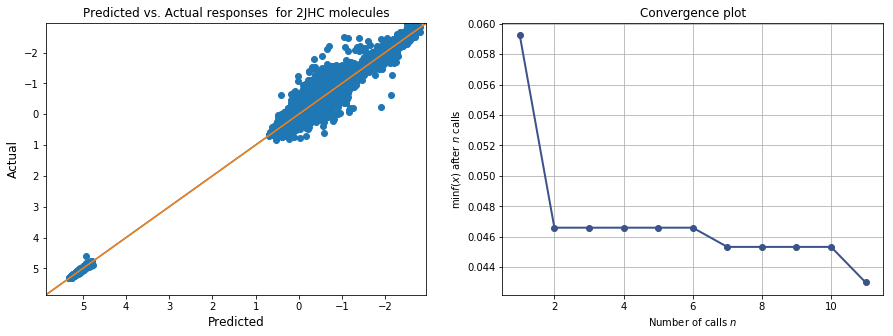

3JHC
            Working with type 3JHC
Started at Thu Aug 15 22:06:11 2019

There are 33 columns to remove.
After dropping 62 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min_diff', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_mean', 'molecule_atom_1_dist_min_diff', 'molecule_atom_1_dist_min_div', 'molecule_atom_1_dist_std_diff', 'molecule_type_0_dist_std_diff', 'molecule_type_dist_mean_diff', 'molecule_type_dist_mean_div', 'molecule_type

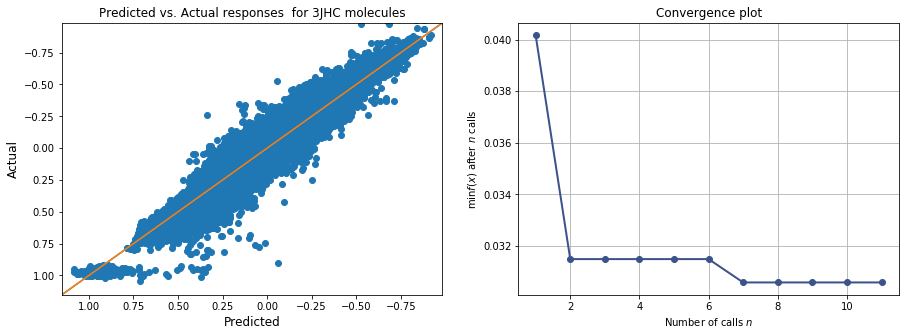

2JHH
            Working with type 2JHH
Started at Fri Aug 16 05:54:45 2019

There are 36 columns to remove.
After dropping 59 features remain
['atom_index_1', 'elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'y_1', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max', 'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std',

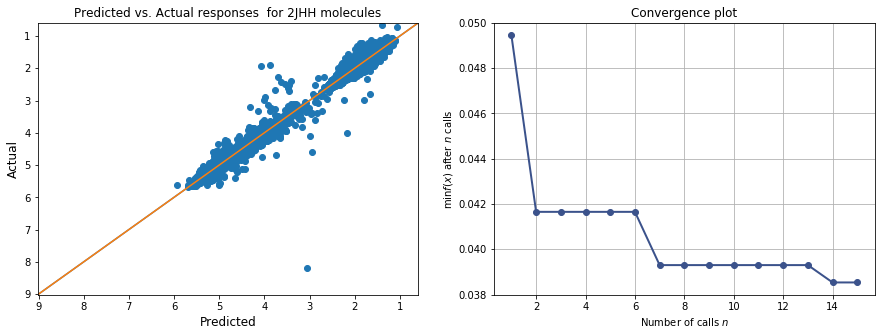

1JHC
            Working with type 1JHC
Started at Fri Aug 16 08:33:53 2019

There are 39 columns to remove.
After dropping 56 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'x_1', 'y_1', 'z_1', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std_diff', 'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_mean', 'mole

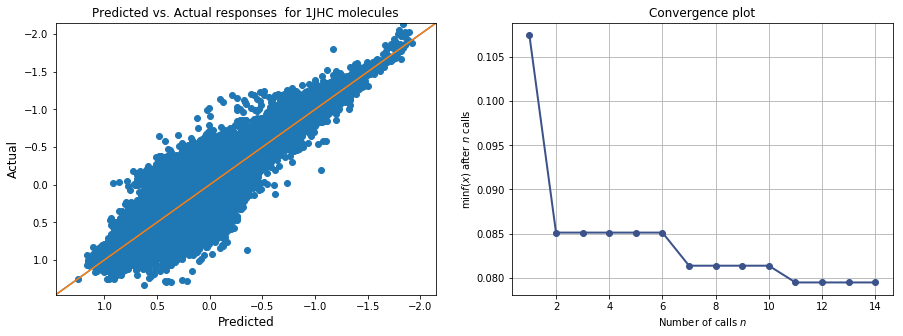

3JHH
            Working with type 3JHH
Started at Fri Aug 16 11:40:53 2019

There are 35 columns to remove.
After dropping 60 features remain
['atom_index_1', 'elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min_diff', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min_diff', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_min_diff', 'molecule_atom_1_dist_min_div', 'molec

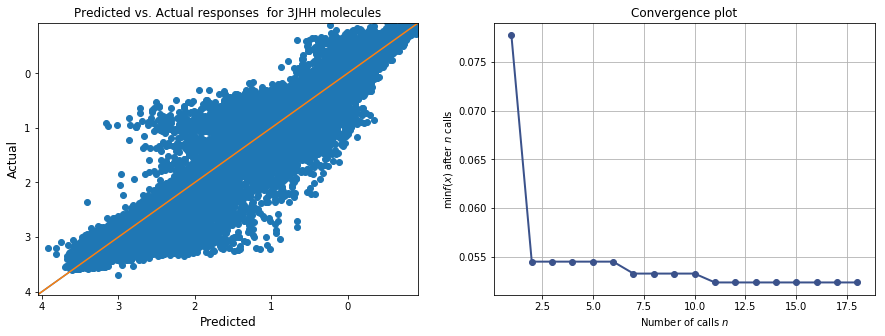

3JHN
            Working with type 3JHN
Started at Fri Aug 16 14:37:44 2019

There are 34 columns to remove.
After dropping 61 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min_diff', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min_diff', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std', 'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_min', 'molecule_atom_1_dist_min_diff', 'molecule_atom_1_dist_min_div', 'molecule_atom_1_dist_std', 'molecule

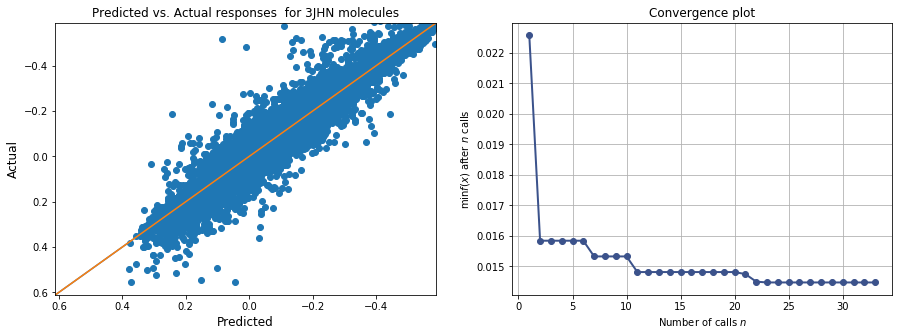

2JHN
            Working with type 2JHN
Started at Fri Aug 16 16:33:03 2019

There are 36 columns to remove.
After dropping 59 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min_diff', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min_diff', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_min', 'molecule_atom_1_d

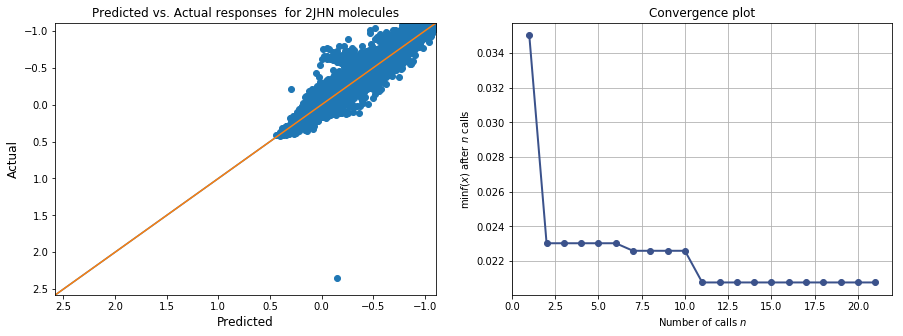

1JHN
            Working with type 1JHN
Started at Fri Aug 16 17:01:54 2019

There are 41 columns to remove.
After dropping 54 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'x_1', 'y_1', 'z_1', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max', 'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std', 'molecule_atom_index_1_dist_std_diff', 'mol

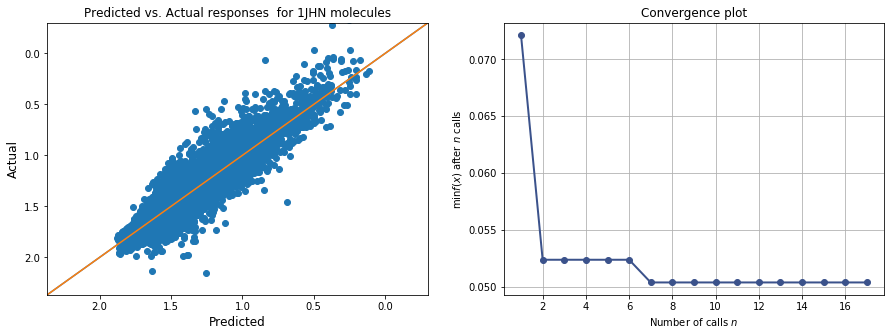


**********************************************************************
            Processing sign_SCC
**********************************************************************
(4658147, 96) (2505542, 96) (4658147,)
            Working with type 2JHC
Started at Fri Aug 16 17:19:13 2019

There are 31 columns to remove.
After dropping 65 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min_diff', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min

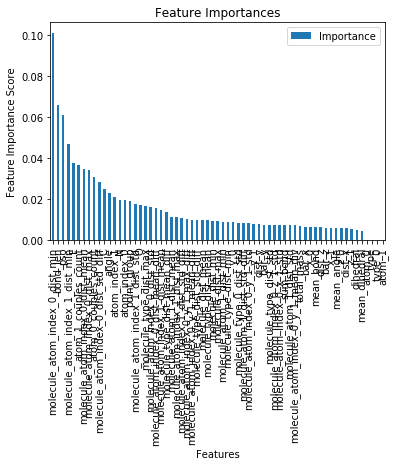

                               Features  Importance
46       molecule_atom_index_0_dist_min    0.101044
4                              bond_len    0.065665
3                                   pso    0.060677
51       molecule_atom_index_1_dist_min    0.046561
19                                    F    0.037391
36                 atom_1_couples_count    0.036479
43      molecule_atom_index_0_dist_mean    0.034496
45       molecule_atom_index_0_dist_max    0.033921
35                 atom_0_couples_count    0.030676
48  molecule_atom_index_0_dist_std_diff    0.028043
            Working with type 3JHC
Started at Fri Aug 16 21:19:40 2019

There are 30 columns to remove.
After dropping 66 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_in

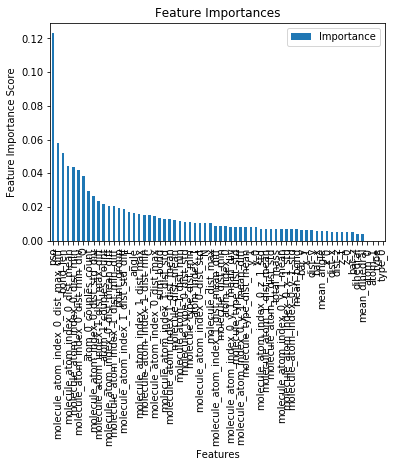

                               Features  Importance
3                                   pso    0.122977
46  molecule_atom_index_0_dist_max_diff    0.057810
4                              bond_len    0.051982
43      molecule_atom_index_0_dist_mean    0.044567
47       molecule_atom_index_0_dist_min    0.043795
48   molecule_atom_index_0_dist_min_div    0.041982
18                                    O    0.038397
35                 atom_0_couples_count    0.029659
50   molecule_atom_index_0_dist_std_div    0.026489
54  molecule_atom_index_1_dist_max_diff    0.023368
            Working with type 2JHH
Started at Sat Aug 17 01:03:44 2019

There are 36 columns to remove.
After dropping 60 features remain
['atom_index_1', 'elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'y_1', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_y_1_max_diff',

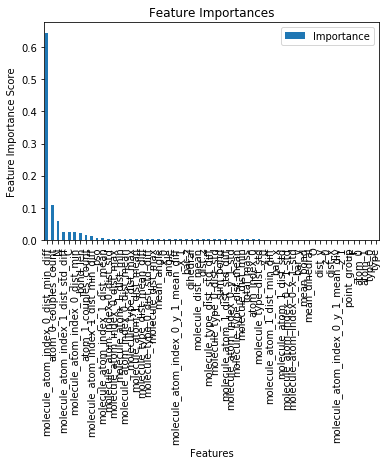

                               Features  Importance
43  molecule_atom_index_0_dist_min_diff    0.645304
33                 atom_0_couples_count    0.109794
16                                    N    0.059452
47  molecule_atom_index_1_dist_std_diff    0.024323
15                                    C    0.024290
42       molecule_atom_index_0_dist_min    0.023550
3                              bond_len    0.021443
34                 atom_1_couples_count    0.015334
46  molecule_atom_index_1_dist_min_diff    0.010331
2                                   pso    0.006416
            Working with type 1JHC
Started at Sat Aug 17 01:17:29 2019

There are 37 columns to remove.
After dropping 59 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'x_1', 'y_1', 'z_1', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_dist_mean_diff',

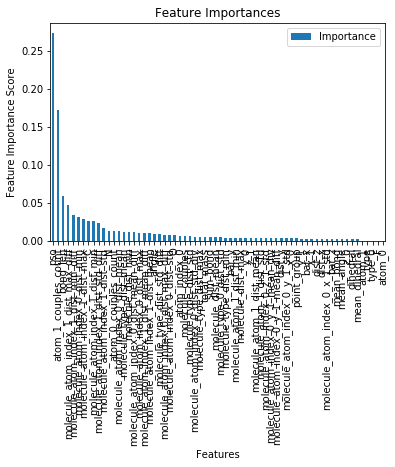

                               Features  Importance
2                                   pso    0.272940
36                 atom_1_couples_count    0.172693
3                              bond_len    0.058544
52  molecule_atom_index_1_dist_max_diff    0.047459
54  molecule_atom_index_1_dist_min_diff    0.033814
46       molecule_atom_index_0_dist_min    0.031301
51       molecule_atom_index_1_dist_max    0.028972
15                                    C    0.026110
53       molecule_atom_index_1_dist_min    0.025137
56  molecule_atom_index_1_dist_std_diff    0.023553
            Working with type 3JHN
Started at Sat Aug 17 02:08:48 2019

There are 28 columns to remove.
After dropping 68 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_in

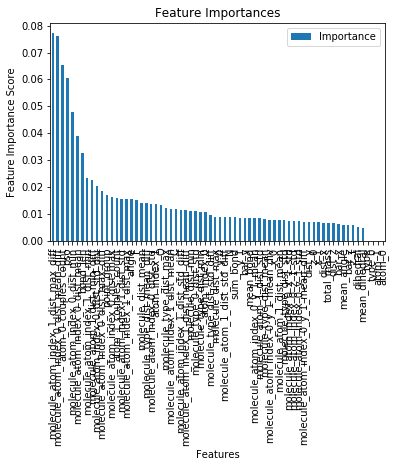

                                Features  Importance
53   molecule_atom_index_1_dist_max_diff    0.077103
44  molecule_atom_index_0_dist_mean_diff    0.076121
35                  atom_0_couples_count    0.065541
3                                    pso    0.060403
47        molecule_atom_index_0_dist_min    0.047785
43       molecule_atom_index_0_dist_mean    0.038870
4                               bond_len    0.032593
54        molecule_atom_index_1_dist_min    0.023390
58         molecule_atom_1_dist_min_diff    0.022587
49    molecule_atom_index_0_dist_std_div    0.020305
            Working with type 2JHN
Started at Sat Aug 17 02:44:11 2019

There are 33 columns to remove.
After dropping 63 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_dist_mean_diff', 'molecule

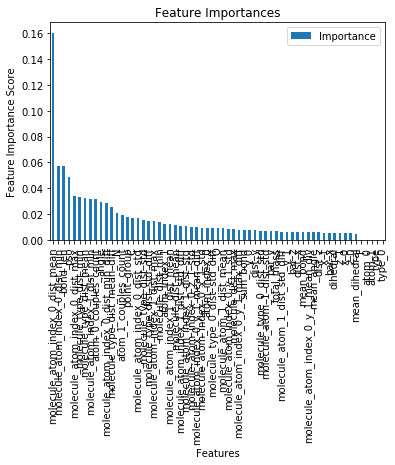

                           Features  Importance
43  molecule_atom_index_0_dist_mean    0.160423
45   molecule_atom_index_0_dist_min    0.057339
4                          bond_len    0.056875
3                               pso    0.048805
44   molecule_atom_index_0_dist_max    0.034129
60           molecule_type_dist_min    0.032943
58          molecule_type_dist_mean    0.032404
50   molecule_atom_index_1_dist_min    0.031898
35             atom_0_couples_count    0.031252
5                             angle    0.029262
            Working with type 1JHN
Started at Sat Aug 17 02:59:35 2019

There are 37 columns to remove.
After dropping 59 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'x_1', 'y_1', 'z_1', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'mol

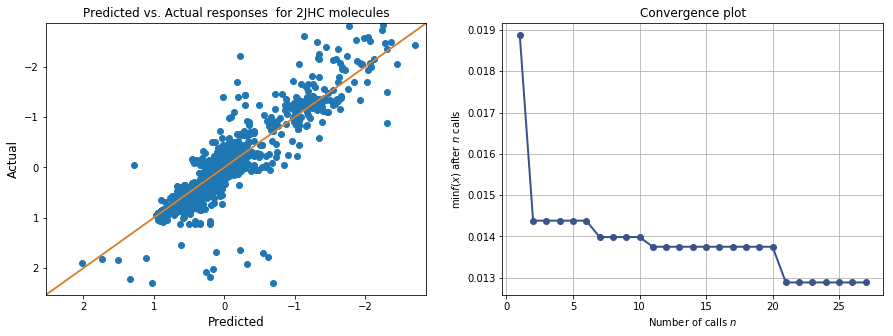

3JHC
            Working with type 3JHC
Started at Sat Aug 17 11:20:36 2019

There are 33 columns to remove.
After dropping 64 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min_diff', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_mean', 'molecule_atom_1_dist_min_diff', 'molecule_atom_1_dist_min_div', 'molecule_atom_1_dist_std_diff', 'molecule_type_0_dist_std_diff', 'molecule_type_dist_mean_diff', 'molecule_type_dist_mean_div', 'molecule_type

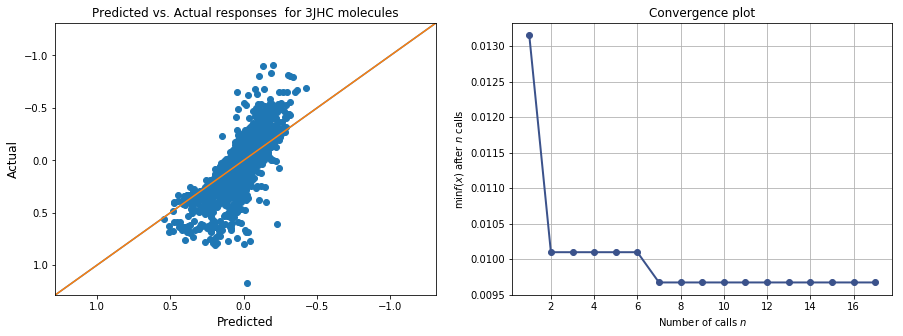

2JHH
            Working with type 2JHH
Started at Sat Aug 17 15:07:31 2019

There are 37 columns to remove.
After dropping 60 features remain
['atom_index_1', 'elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'y_1', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max', 'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min', 'molecule_atom_index_1_dist_min_div',

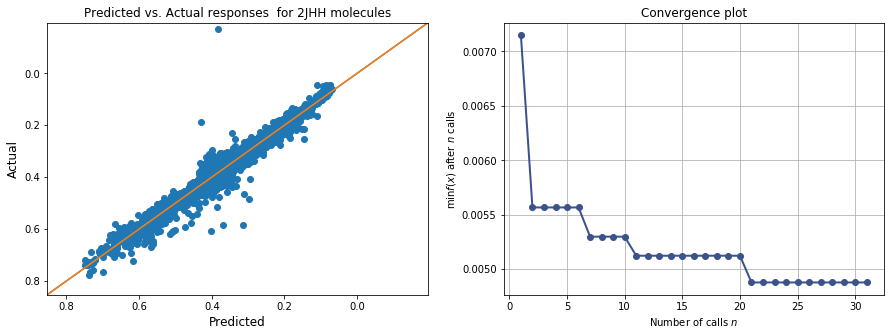

1JHC
            Working with type 1JHC
Started at Sat Aug 17 17:07:46 2019

There are 39 columns to remove.
After dropping 58 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'x_1', 'y_1', 'z_1', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std_diff', 'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_mean', 'mole

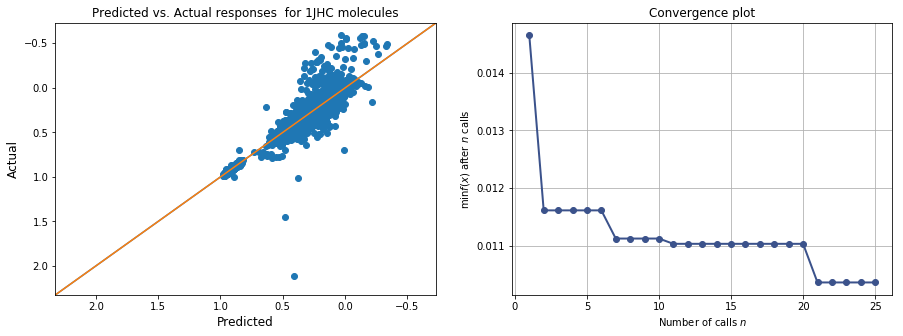

3JHH
            Working with type 3JHH
Started at Sat Aug 17 21:28:23 2019

There are 35 columns to remove.
After dropping 62 features remain
['atom_index_1', 'elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min_diff', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min_diff', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_min_diff', 'molecule_atom_1_dist_min_div', 'molec

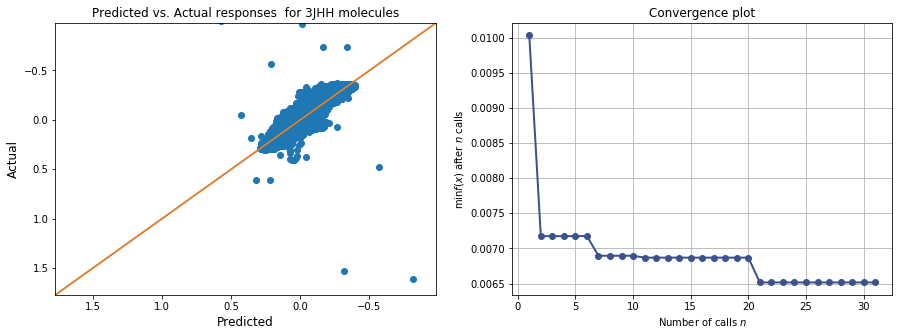

3JHN
            Working with type 3JHN
Started at Sun Aug 18 00:54:45 2019

There are 34 columns to remove.
After dropping 63 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min_diff', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min_diff', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std', 'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_min', 'molecule_atom_1_dist_min_diff', 'molecule_atom_1_dist_min_div', 'molecule_atom_1_dist_std', 'molecule

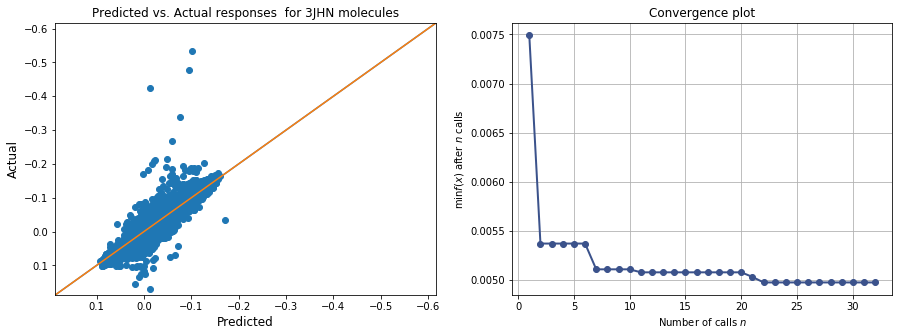

2JHN
            Working with type 2JHN
Started at Sun Aug 18 01:53:58 2019

There are 36 columns to remove.
After dropping 61 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min_diff', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min_diff', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_min', 'molecule_atom_1_d

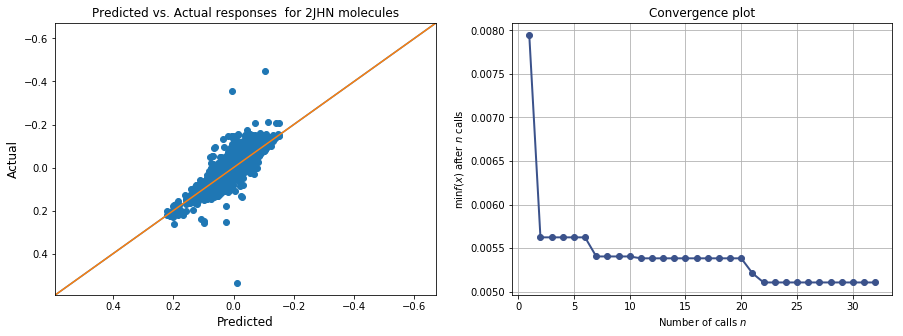

1JHN
            Working with type 1JHN
Started at Sun Aug 18 02:45:55 2019

There are 41 columns to remove.
After dropping 56 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'x_1', 'y_1', 'z_1', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max', 'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std', 'molecule_atom_index_1_dist_std_diff', 'mol

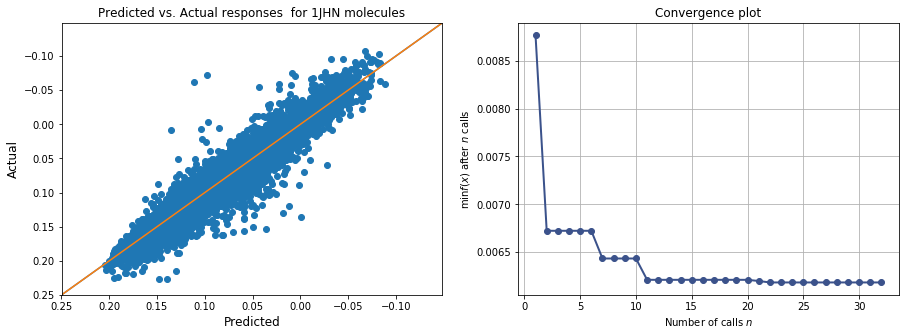


**********************************************************************
            Processing dso
**********************************************************************
(4658147, 98) (2505542, 98) (4658147,)
2JHC
            Working with type 2JHC
Started at Sun Aug 18 03:09:28 2019

There are 34 columns to remove.
After dropping 64 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min_diff', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min

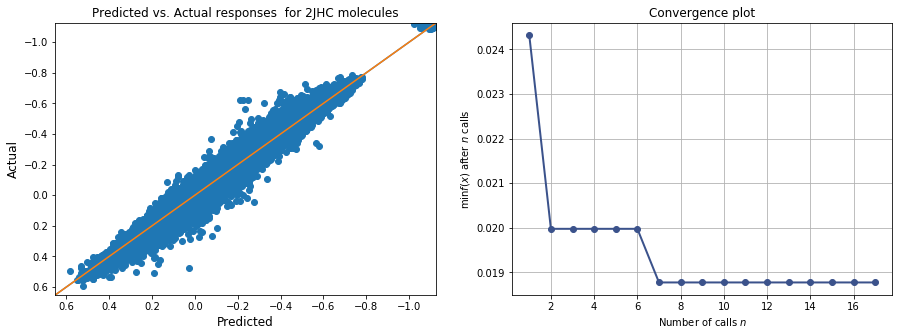

3JHC
            Working with type 3JHC
Started at Sun Aug 18 06:30:27 2019

There are 33 columns to remove.
After dropping 65 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min_diff', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_mean', 'molecule_atom_1_dist_min_diff', 'molecule_atom_1_dist_min_div', 'molecule_atom_1_dist_std_diff', 'molecule_type_0_dist_std_diff', 'molecule_type_dist_mean_diff', 'molecule_type_dist_mean_div', 'molecule_type

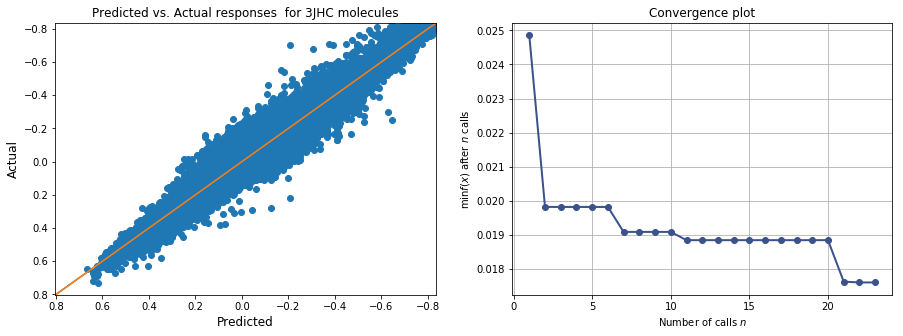

2JHH
            Working with type 2JHH
Started at Sun Aug 18 15:53:36 2019

There are 37 columns to remove.
After dropping 61 features remain
['atom_index_1', 'elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'y_1', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max', 'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min', 'molecule_atom_index_1_dist_min_div',

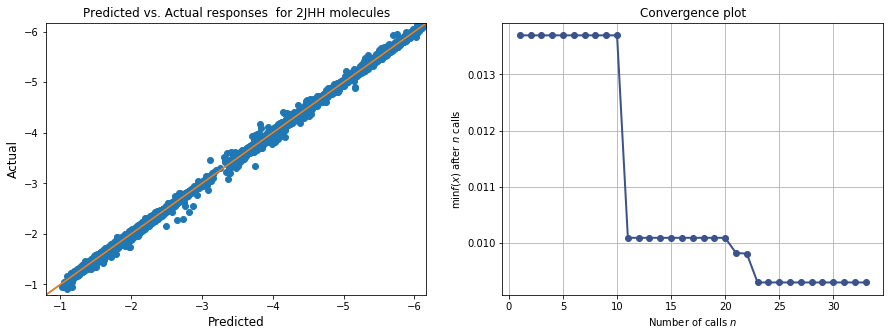

1JHC
            Working with type 1JHC
Started at Sun Aug 18 18:13:50 2019

There are 39 columns to remove.
After dropping 59 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'x_1', 'y_1', 'z_1', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std_diff', 'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_mean', 'mole

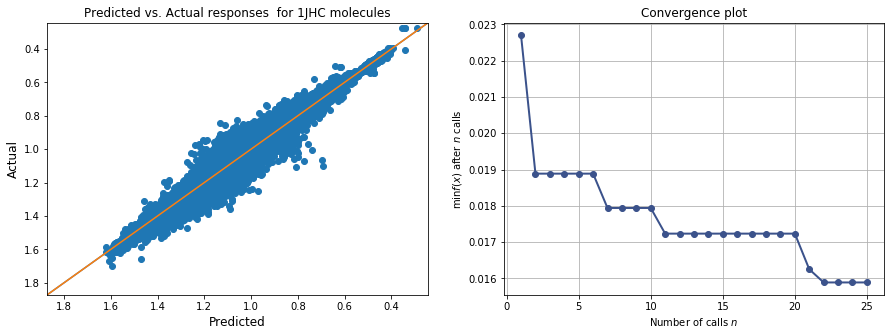

3JHH
            Working with type 3JHH
Started at Sun Aug 18 22:15:30 2019

There are 35 columns to remove.
After dropping 63 features remain
['atom_index_1', 'elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min_diff', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min_diff', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_min_diff', 'molecule_atom_1_dist_min_div', 'molec

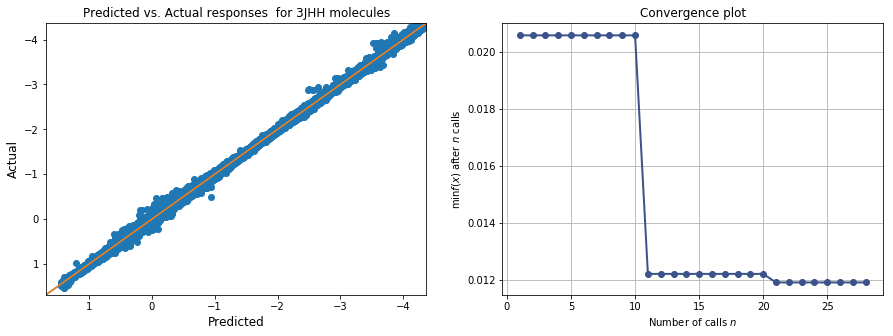

3JHN
            Working with type 3JHN
Started at Mon Aug 19 02:39:26 2019

There are 34 columns to remove.
After dropping 64 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min_diff', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min_diff', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std', 'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_min', 'molecule_atom_1_dist_min_diff', 'molecule_atom_1_dist_min_div', 'molecule_atom_1_dist_std', 'molecule

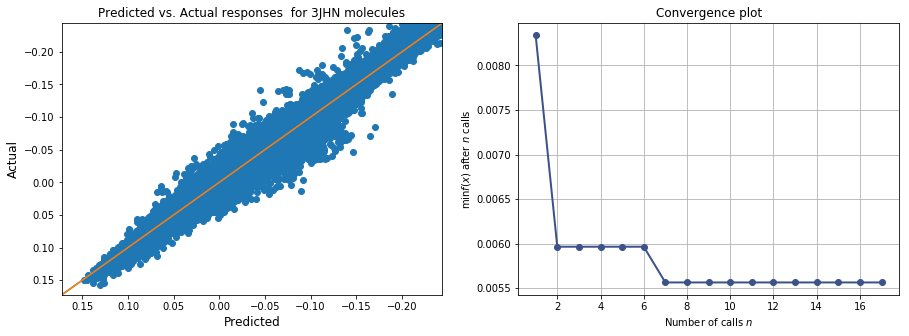

2JHN
            Working with type 2JHN
Started at Mon Aug 19 03:12:32 2019

There are 36 columns to remove.
After dropping 62 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min_diff', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min_diff', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_min', 'molecule_atom_1_d

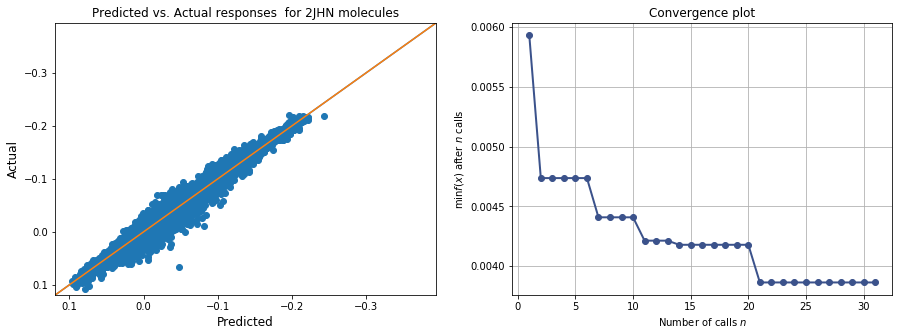

1JHN
            Working with type 1JHN
Started at Mon Aug 19 03:47:51 2019

There are 42 columns to remove.
After dropping 56 features remain
['bond_len', 'elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'x_1', 'y_1', 'z_1', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_dist_mean_diff', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min', 'molecule_atom_index_0_dist_std_diff', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max', 'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dist_min', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_dist_std', 'molecule_atom_index_1_dist_std

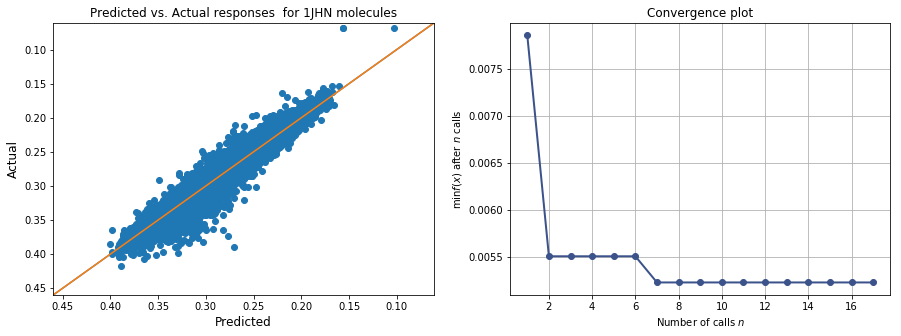


**********************************************************************
            Processing k_tensor
**********************************************************************
(4658147, 99) (2505542, 99) (4658147,)
2JHC
            Working with type 2JHC
Started at Mon Aug 19 04:03:53 2019

There are 34 columns to remove.
After dropping 65 features remain
['elect_num', 'cent_mass_x', 'cent_mass_y', 'cent_mass_z', 'centroid_x', 'centroid_y', 'centroid_z', 'sum_angle', 'sum_dihedral', 'H', 'dist', 'molecule_couples', 'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min_diff', 'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_mean_diff', 'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_1_dist_max_div', 'molecule_atom_index_1_dis

KeyboardInterrupt: 

In [35]:
frac = 1

all_notin = ['scalar_coupling_constant', 'k_tensor', 'sd', 'pso', 'dso', 'sign_SCC']

for meta_feature in [ 'pso', 'sign_SCC', 'sd','dso', 'k_tensor']: 
    
    print('\n'+'*'*70 + '\n' + ' '*12 + f'Processing {meta_feature}' + '\n' +'*'*70)
    
    col = [c for c in train.columns if c not in all_notin]
    
    X = train.sample(frac = frac, random_state = RANDOM_STATE)[col]
    Y = train.loc[X.index, meta_feature]
    X_TEST = test[col]
    print(X.shape, X_TEST.shape, Y.shape)
    
    if meta_feature in ['sign_SCC']:
        preds_meta = calc_meta_feature_class(X, X_TEST, Y, check_classification = True) 
    else:
        preds_meta = calc_meta_feature_regression(X, X_TEST, Y)
    
    test[meta_feature] = preds_meta
    all_notin.remove(meta_feature)
    test.to_csv('metas_test.csv', index = False)
train.to_csv('metas_train.csv', index = False)